In [27]:
import math

In [2]:
import importlib
import network
importlib.reload(network)
import os
from random import shuffle
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms
from torchvision import datasets, utils
import pickle
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch import utils
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

In [3]:
import glob
import random
import PIL
if not os.path.exists("statistics.pkl"):
    files = glob.glob("images/**/*.jpg")
    subset = random.choices(files, k=3000)
    images = []
    for im in subset:
        with PIL.Image.open(im) as f:
            images.append(np.asarray(f) / 256)
    arr = np.stack(images)
    mean = arr.mean(axis=(0, 1, 2))
    std = arr.std(axis=(0, 1, 2))
    with open('statistics.pkl', 'wb+') as stat:
        pickle.dump((mean, std), stat)
else:
    with open('statistics.pkl', 'rb') as stat:
        print("READING")
        mean, std = pickle.load(stat)
print(mean, std)


READING
[0.42716227 0.45460954 0.44991944] [0.2543999  0.2460573  0.27638961]


In [38]:
def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''
    im = image.copy()
    for t in range(3):
        im[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return im

In [39]:
batch_size = 1
num_workers = 2

In [40]:
secret_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        'images/',
        transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])), batch_size=batch_size, num_workers=num_workers,
    pin_memory=True, shuffle=True, drop_last=True)
cover_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        'images/',
        transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])), batch_size=batch_size, num_workers=num_workers,
    pin_memory=True, shuffle=True, drop_last=True)

In [83]:
model = torch.load('models/deep-3-epoch-N1.pkl')

In [84]:
def test(model):
    model.eval()
    secret_rmse = []
    covered_rmse = []
    outputs = []
    # Iterate over batches performing forward and backward passes
    for idx, (train_secret, train_cover) in enumerate(zip(secret_loader, cover_loader)):
        # this is the cover the recovered secret
        train_hidden, train_output = model(train_secret[0], train_cover[0])
        # Calculate loss and perform backprop
        train_loss_cover = np.mean((denormalize(train_cover[0].detach().squeeze(0).numpy(), std, mean) - 
            denormalize(train_hidden.detach().squeeze(0).numpy(), std, mean)) ** 2)
        train_loss_secret = np.mean((denormalize(train_secret[0].detach().squeeze(0).numpy(), std, mean) -
            denormalize(train_output.detach().squeeze(0).numpy(), std, mean)) ** 2)
        
        # Saves training loss
        covered_rmse.append(train_loss_cover.item())
        secret_rmse.append(train_loss_secret.item())

        # Prints mini-batch losses
        if idx in {0, 1, 2, 3}:
            outputs.append((train_secret[0], train_cover[0], train_hidden, train_output))
        if idx > 60:
            break
    return secret_rmse, covered_rmse, outputs 

In [85]:
secret, covered, outputs = test(model)

In [90]:
np.mean([math.sqrt(a) for a in secret])

0.08473380317411174

In [91]:
np.mean([math.sqrt(a) for a in covered])

0.05611337540307718

In [92]:
def show(images):
    fig, ax = plt.subplots(len(images), 4, figsize=(15, 15))
    titles = ["Actual Secret", "Actual Cover", "Hidden", "Recovered Secret"]
    for i, row in enumerate(images):
        for j in range(4):
            if i == 0:
                ax[i, j].set_title(titles[j])
            ax[i, j].imshow(denormalize(row[j].squeeze(0).detach().numpy(), std, mean).transpose((1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


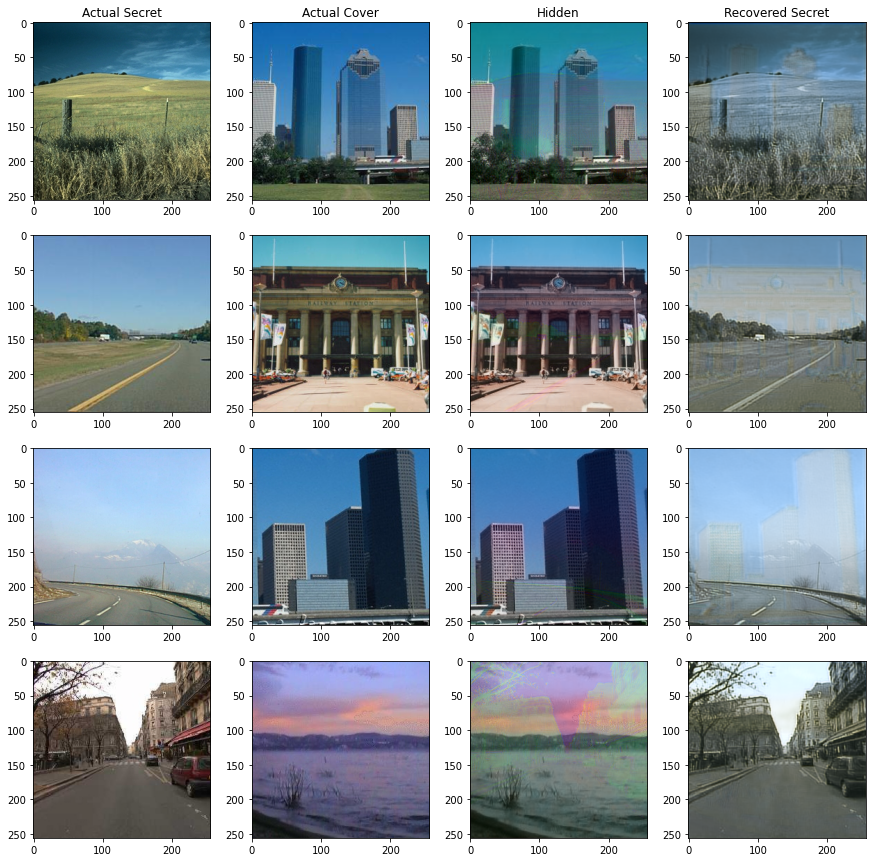

In [93]:
show(outputs)